In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from pytrends.request import TrendReq
import us
import datetime
import json
import requests
import gmaps
import os
from scipy import stats
from census import Census
from config import (census_key, gkey)
import seaborn as sns
from matplotlib import cm


pytrends = TrendReq(hl='en-US', tz=360, retries=10, backoff_factor=0.5)

In [5]:
yeezycsvpath="Resources/Even Cleaner StockX Data.csv"
yeezydata = pd.read_csv(yeezycsvpath)

#convert date strings to datetime
yeezydata['Order Date'] = pd.to_datetime(yeezydata['Order Date'])
yeezydata['Release Date'] = pd.to_datetime(yeezydata['Release Date'])


#preview data


In [6]:
sd = yeezydata.groupby(['Buyer Region'])
unitssold=sd['Shoe Size'].count()
totalprofit=sd['Profit Margin ($)'].sum()

newdf=pd.DataFrame({'Units Sold':unitssold,
             'Profit':totalprofit,
             'Average Dollar':totalprofit/unitssold})
newdf['Lat']=""
newdf['Lng']=""
newdf=newdf.reset_index()


In [7]:
params1 = {"key": gkey}

# Loop through the cities_pd and run a lat/long search for each city
for index, row in newdf.iterrows():
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"

    state1 = row['Buyer Region']

    # update address key value
    params1['address'] = f"{state1}"

    # make request
    cities_lat_lng1 = requests.get(base_url, params=params1)
    
    # print the cities_lat_lng url, avoid doing for public github repos in order to avoid exposing key
    # print(cities_lat_lng.url)
    
    # convert to json
    cities_lat_lng1 = cities_lat_lng1.json()

    newdf.loc[index, "Lat"] = cities_lat_lng1["results"][0]["geometry"]["location"]["lat"]
    newdf.loc[index, "Lng"] = cities_lat_lng1["results"][0]["geometry"]["location"]["lng"]

# Visualize to confirm lat lng appear



In [8]:


sd = yeezydata.groupby(['Buyer Region','Shoe Type'])['Profit Margin ($)'].sum().reset_index()
sd1=sd
sd['Lat']=""
sd['Lng']=""
sd


,Buyer Region,Shoe Type,Profit Margin ($),Lat,Lng
0,Alabama,Air Force 1,2147,,
1,Alabama,Air Jordan 1 Retro,8467,,
2,Alabama,Air Max 90,1959,,
3,Alabama,Air Max 97,3903,,
4,Alabama,Air Presto,7402,,
...,...,...,...,...,...
471,Wisconsin,Vapor Max,25120,,
472,Wisconsin,Yeezy Boost 350,84869,,
473,Wisconsin,Zoom Fly,2500,,
474,Wyoming,Air Max 97,410,,


In [9]:
params = {"key": gkey}

# Loop through the cities_pd and run a lat/long search for each city
for index, row in sd.iterrows():
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"

    state = row['Buyer Region']

    # update address key value
    params['address'] = f"{state}"

    # make request
    cities_lat_lng = requests.get(base_url, params=params)
    
    # print the cities_lat_lng url, avoid doing for public github repos in order to avoid exposing key
    # print(cities_lat_lng.url)
    
    # convert to json
    cities_lat_lng = cities_lat_lng.json()

    sd.loc[index, "Lat"] = cities_lat_lng["results"][0]["geometry"]["location"]["lat"]
    sd.loc[index, "Lng"] = cities_lat_lng["results"][0]["geometry"]["location"]["lng"]

# Visualize to confirm lat lng appear



In [10]:
humidity = sd["Profit Margin ($)"].astype(float)
maxhumidity = humidity.max()
locations = sd[["Lat", "Lng"]]


fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=humidity,dissipating=False, max_intensity=maxhumidity,point_radius=3)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [11]:
#Map that shows where is most likely to spend $$ for sneaker

humidity1 = newdf["Average Dollar"].astype(float)
maxhumidity1 = humidity1.max()
locations1 = newdf[["Lat", "Lng"]]


fig1 = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations1, weights=humidity1,dissipating=False, max_intensity=maxhumidity1,point_radius=3)
fig1.add_layer(heat_layer)
fig1


Figure(layout=FigureLayout(height='420px'))

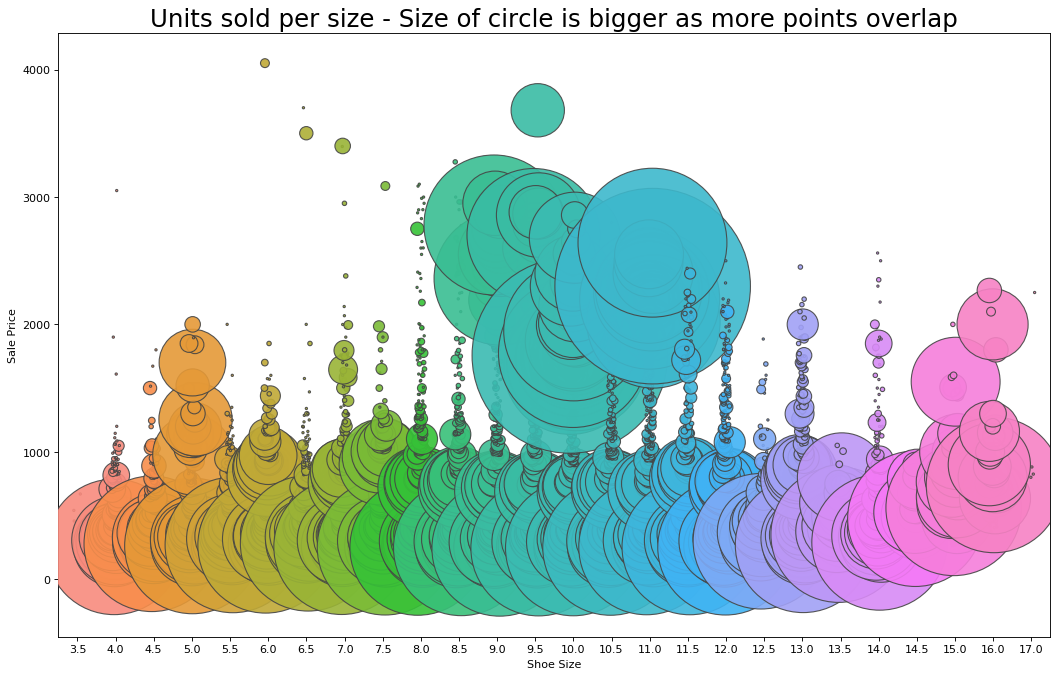

In [12]:
# Import Data

dfcounts = yeezydata.groupby(['Shoe Size', 'Sale Price']).size().reset_index(name='counts')
dfcounts

# Draw Stripplot
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)    
sns.stripplot(dfcounts['Shoe Size'], dfcounts['Sale Price'], size=dfcounts.counts*2, ax=ax, alpha=0.9,edgecolor="gray",linewidth=1)

# Decorations
plt.title('Units sold per size - Size of circle is bigger as more points overlap', fontsize=22)
plt.savefig("Units_sold_per_size.png")
plt.show()

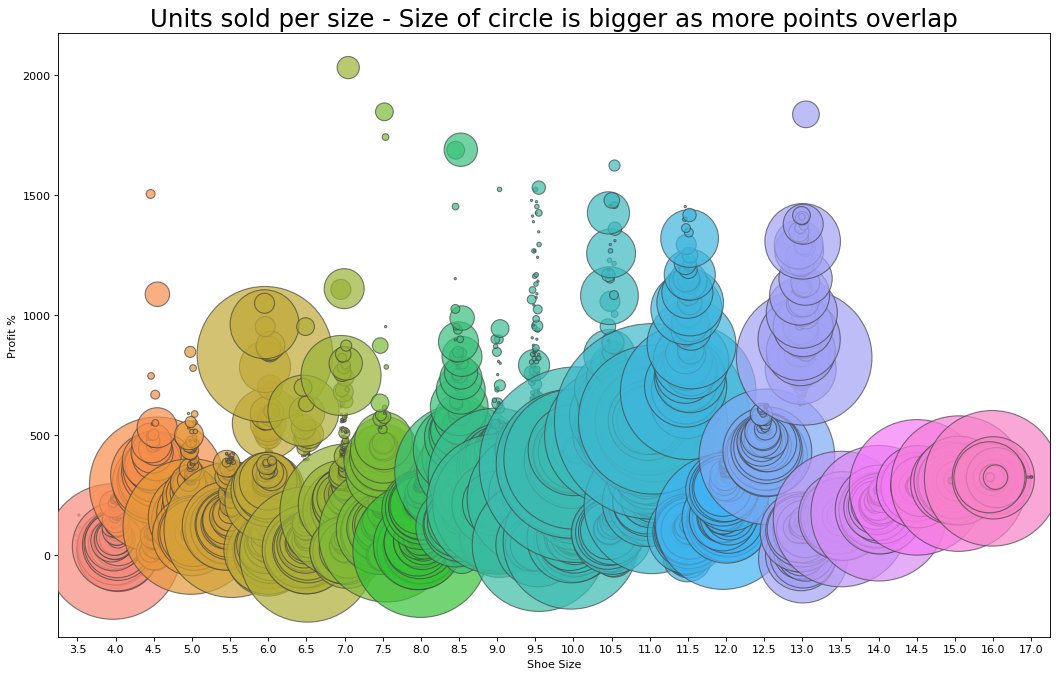

In [14]:
# Import Data

dfcounts1 = yeezydata.groupby(['Shoe Size', 'Profit %']).size().reset_index(name='counts')
dfcounts1

# Draw Stripplot
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)    
sns.stripplot(dfcounts['Shoe Size'], dfcounts1['Profit %'], size=dfcounts.counts*2, ax=ax, alpha=0.7, edgecolor="gray",linewidth=1)

# Decorations
plt.title('Units sold per size - Size of circle is bigger as more points overlap', fontsize=22)
plt.savefig("Units_sold_per_size_profitpercent.png")
plt.show()

Index(['Order Date', 'Brand', 'Sneaker Name', 'Sale Price', 'Retail Price',
       'Release Date', 'Shoe Size', 'Buyer Region', 'Shoe Type',
       'Profit Margin ($)', 'Profit %', 'Days Since Launch', 'State', 'Year',
       'Week Number', 'Google Trend Score (State)',
       'Google Trend Score (National)'],
      dtype='object')

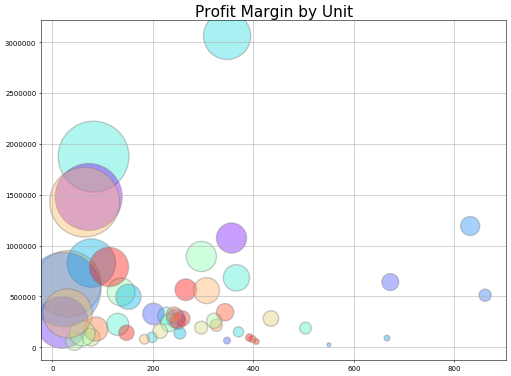

In [18]:
bubblecount = yeezydata.groupby('Sneaker Name').agg({"Profit %":["mean"], "Shoe Size": ["count"], "Profit Margin ($)":["sum"]})


x = bubblecount["Profit %"]["mean"]
y = bubblecount["Profit Margin ($)"]["sum"]
z = bubblecount["Shoe Size"]["count"]
colors=cm.rainbow(np.random.rand(50))
# use the scatter function
plt.figure(figsize=(12, 9), dpi=50)
plt.scatter(x, y, s=z,c=colors,alpha=0.4, edgecolors="grey", linewidth=2)

plt.title('Profit Margin by Unit', fontsize=22)
plt.grid(True)
plt.savefig("Profit_margin_unit.png")
plt.show()

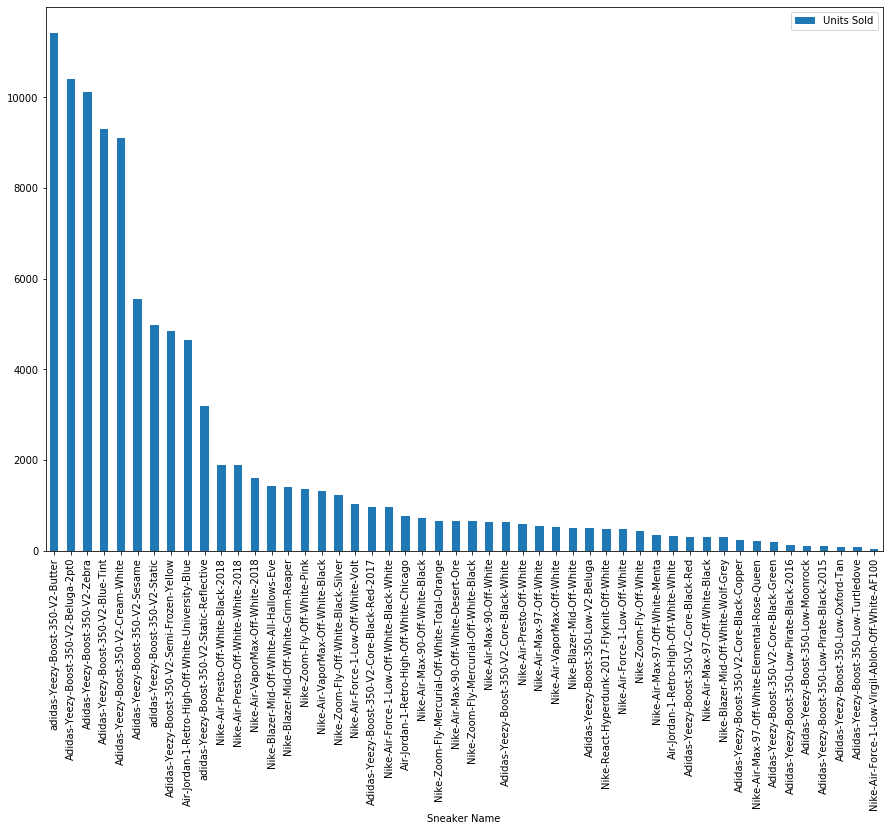

In [21]:
newsdd1 = yeezydata.groupby(['Sneaker Name'])['Shoe Size'].count().reset_index()
newsdd1=newsdd1.rename(columns={"Shoe Size": "Units Sold"})
newsdd1=newsdd1.sort_values('Units Sold',ascending=False)

axss1 = newsdd1.plot.bar(x='Sneaker Name', y='Units Sold', rot=90,figsize=(15,10))
plt.title("Units Sold")
plt.savefig("Profit_margin_unit.png")

In [22]:
# sd3 = yeezydata.groupby(['Buyer Region','Shoe Type'])['Profit Margin ($)'].mean().reset_index()
# sd3['Lat']=""
# sd3["Lng"]=""

# params = {"key": gkey}

# # Loop through the cities_pd and run a lat/long search for each city
# for index, row in sd3.iterrows():
#     base_url = "https://maps.googleapis.com/maps/api/geocode/json"

#     state6 = row['Buyer Region']

#     # update address key value
#     params['address'] = f"{state6}"

#     # make request
#     cities_lat_lng6 = requests.get(base_url, params=params)
    
#     # print the cities_lat_lng url, avoid doing for public github repos in order to avoid exposing key
#     # print(cities_lat_lng.url)
    
#     # convert to json
#     cities_lat_lng6 = cities_lat_lng6.json()

#     sd3.loc[index, "Lat"] = cities_lat_lng6["results"][0]["geometry"]["location"]["lat"]
#     sd3.loc[index, "Lng"] = cities_lat_lng6["results"][0]["geometry"]["location"]["lng"]

# # Visualize to confirm lat lng appear



In [23]:

# newindex = sd.set_index('Shoe Type')
# jordan1 = newindex.loc['Air Jordan 1 Retro', :]
# #Jordan 1
# jordanssold = jordan1["Profit Margin ($)"].astype(float)
# maxjsold = jordanssold.max()
# jordanlocations = jordan1[["Lat", "Lng"]]

# fig5 = gmaps.figure()
# heat_layer = gmaps.heatmap_layer(jordanlocations, weights=jordanssold,dissipating=False, max_intensity=maxjsold,point_radius=3)
# fig5.add_layer(heat_layer)
# fig5

Figure(layout=FigureLayout(height='420px'))

In [31]:
# newindex = sd.set_index('Shoe Type')
# airmax = newindex.loc['Air Max 90', :]
# airmaxsold = airmax["Profit Margin ($)"].astype(float)
# airmaxmax = airmaxsold.max()
# airmaxlocations = airmax[["Lat", "Lng"]]

# fig5 = gmaps.figure()
# heat_layer = gmaps.heatmap_layer(airmaxlocations, weights=airmaxsold,dissipating=False, max_intensity=airmaxmax,point_radius=3)
# fig5.add_layer(heat_layer)
# fig5


# # newindex = sd.set_index('Shoe Type')
# # jordan1 = newindex.loc['Air Jordan 1 Retro', :]
# # #Jordan 1
# # jordanssold = jordan1["Profit Margin ($)"].astype(float)
# # maxjsold = jordanssold.max()
# # jordanlocations = jordan1[["Lat", "Lng"]]

Figure(layout=FigureLayout(height='420px'))

In [ ]:
# # Run Census Search to retrieve data on all zip codes (2013 ACS5 Census)
# # See: https://github.com/CommerceDataService/census-wrapper for library documentation
# # See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels
# census_data = c.acs5.get(("B01003_001E", "B17001_002E"), {'for': 'zip code tabulation area:*'})

# # Convert to DataFrame
# census_pd = pd.DataFrame(census_data)

# # Column Reordering
# census_pd = census_pd.rename(columns={"B01003_001E": "Population",
#                                       "B17001_002E": "Poverty Count",
#                                       "zip code tabulation area": "Zipcode"})

# # Add in Poverty Rate (Poverty Count / Population)
# census_pd["Poverty Rate"] = 100 * \
#     census_pd["Poverty Count"].astype(
#         int) / census_pd["Population"].astype(int)

# # Final DataFrame
# census_pd = census_pd[["Zipcode", "Population", "Poverty Rate"]]

# # Visualize
# print(len(census_pd))
# census_pd.head()

In [ ]:
# # scatter plot with scatter() function
# # transparency with "alpha"
# # bubble size with "s"
# # color the bubbles with "c"
# plt.scatter('X', 'Y',
#              s='bubble_size',
#              c='Colors',
#              alpha=0.5, data=df)
# plt.xlabel("X", size=16)
# plt.ylabel("y", size=16)
# plt.title("Bubble Plot with Colors: Matplotlib", size=18)

In [ ]:
# newindex3 = sd3.set_index('Shoe Type')
# jordan13 = newindex3.loc['Air Jordan 1 Retro', :]
# #Jordan 1
# jordanssold3 = jordan13["Profit Margin ($)"].astype(float)
# maxjsold3 = jordanssold3.max()
# jordanlocations3 = jordan13[["Lat", "Lng"]]

# fig53 = gmaps.figure()
# heat_layer = gmaps.heatmap_layer(jordanlocations, weights=jordanssold3,dissipating=False, max_intensity=maxjsold3,point_radius=3)
# fig53.add_layer(heat_layer)
# fig53

In [ ]:
# #Average purchase price per region of sneaker

# groupby=yeezydata.groupby(['Buyer Region'])
# solddollars=groupby['Profit Margin ($)'].sum()
# unitssold=groupby['Shoe Size'].count()
# adt=solddollars/unitssold
# adt
# adtdf=pd.DataFrame({
#              "Profit Margin ($)":solddollars,
#              "Units Sold":unitssold,
#              "Average Unit Sold":adt})

# adtdf= adtdf.sort_values('Average Unit Sold',ascending=True)



# ax = adtdf.plot.bar(y='Average Unit Sold', rot=90,figsize=(15,10))
